Basic structure referenced from GAUTAM, T. (2021). Semantic Segmentation is Easy with Pytorch 😎. Kaggle. Retrieved from https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch 

changes has been made, please refer to original link if needed

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip3 install -q segmentation-models-pytorch
!pip3 install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.6 MB/s eta 0:00:00


# Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
n_classes = 17

input_images = "/content/drive/MyDrive/inputs/"
ground_truth =  "/content/drive/MyDrive/semantic_annotations/"

# Initialize an empty list to store the names of the image files
imageNames = np.array([])

# Iterate through the directories and filenames in the specified input_images
for dirname, _, filenames in os.walk(input_images):
    for filename in filenames:
        # Check if the file has a .png extension
        if filename.endswith('.png'):
            # Remove the file extension and append the filename to the names list
            imageNames = np.append(imageNames, filename.split('.')[0])
#split data
X_trainval, X_test = train_test_split(imageNames.values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)


# Dataset

In [8]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, ground_truth, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.ground_truth = ground_truth
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #print(self.ground_truth + self.X[idx] + '.png')
        mask = cv2.imread(self.ground_truth + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        #print(np.unique(mask))
        mask[mask == 255] = 16
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(input_images, ground_truth, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(input_images, ground_truth, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

# Model

In [10]:
#device = torch.device("mps")
print(device)

cuda


In [11]:
model = smp.Unet('vgg16', encoder_weights='imagenet', classes=17, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 362MB/s]


In [12]:
model

Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

# Training

In [13]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [14]:
"""
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=17):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)
"""
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=17):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes - 1):  # loop per pixel class, excluding class 16
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:  # no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            #print(mask)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    #print(mask)
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-resnet18_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
            
        #save model when epoch is 10, 20, 30, 40, 50 in case compute usage is not enough
            if e % 10 == 0:
                torch.save(model,"/content/drive/Unet-vgg16_2.pt")
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [19]:
max_lr = 1e-3
epoch = 40
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.019 
Epoch:1/40.. Train Loss: 1.282.. Val Loss: 1.019.. Train mIoU:0.258.. Val mIoU: 0.320.. Train Acc:0.677.. Val Acc:0.726.. Time: 3.87m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 1.019 >> 0.948 
Epoch:2/40.. Train Loss: 1.037.. Val Loss: 0.948.. Train mIoU:0.297.. Val mIoU: 0.314.. Train Acc:0.712.. Val Acc:0.722.. Time: 3.90m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/40.. Train Loss: 0.990.. Val Loss: 0.961.. Train mIoU:0.295.. Val mIoU: 0.318.. Train Acc:0.709.. Val Acc:0.726.. Time: 3.84m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.961 >> 0.882 
Epoch:4/40.. Train Loss: 0.983.. Val Loss: 0.882.. Train mIoU:0.292.. Val mIoU: 0.317.. Train Acc:0.702.. Val Acc:0.725.. Time: 3.86m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.882 >> 0.859 
saving model...
Epoch:5/40.. Train Loss: 0.944.. Val Loss: 0.859.. Train mIoU:0.294.. Val mIoU: 0.325.. Train Acc:0.710.. Val Acc:0.733.. Time: 3.94m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/40.. Train Loss: 0.940.. Val Loss: 0.963.. Train mIoU:0.296.. Val mIoU: 0.347.. Train Acc:0.710.. Val Acc:0.701.. Time: 3.81m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.963 >> 0.917 
Epoch:7/40.. Train Loss: 0.986.. Val Loss: 0.917.. Train mIoU:0.322.. Val mIoU: 0.361.. Train Acc:0.694.. Val Acc:0.701.. Time: 3.91m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:8/40.. Train Loss: 0.939.. Val Loss: 0.952.. Train mIoU:0.339.. Val mIoU: 0.343.. Train Acc:0.708.. Val Acc:0.694.. Time: 3.87m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.952 >> 0.918 
Epoch:9/40.. Train Loss: 0.932.. Val Loss: 0.918.. Train mIoU:0.342.. Val mIoU: 0.360.. Train Acc:0.709.. Val Acc:0.701.. Time: 3.90m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.918 >> 0.844 
Epoch:10/40.. Train Loss: 0.916.. Val Loss: 0.844.. Train mIoU:0.348.. Val mIoU: 0.386.. Train Acc:0.714.. Val Acc:0.727.. Time: 3.85m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.844 >> 0.828 
Epoch:11/40.. Train Loss: 0.918.. Val Loss: 0.828.. Train mIoU:0.343.. Val mIoU: 0.391.. Train Acc:0.712.. Val Acc:0.734.. Time: 3.89m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.828 >> 0.786 
saving model...
Epoch:12/40.. Train Loss: 0.897.. Val Loss: 0.786.. Train mIoU:0.353.. Val mIoU: 0.397.. Train Acc:0.719.. Val Acc:0.746.. Time: 3.88m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:13/40.. Train Loss: 0.833.. Val Loss: 0.841.. Train mIoU:0.371.. Val mIoU: 0.389.. Train Acc:0.738.. Val Acc:0.724.. Time: 3.86m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.841 >> 0.760 
Epoch:14/40.. Train Loss: 0.814.. Val Loss: 0.760.. Train mIoU:0.380.. Val mIoU: 0.414.. Train Acc:0.745.. Val Acc:0.748.. Time: 3.85m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:15/40.. Train Loss: 0.795.. Val Loss: 0.794.. Train mIoU:0.389.. Val mIoU: 0.401.. Train Acc:0.751.. Val Acc:0.747.. Time: 3.84m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.794 >> 0.714 
Epoch:16/40.. Train Loss: 0.760.. Val Loss: 0.714.. Train mIoU:0.400.. Val mIoU: 0.430.. Train Acc:0.760.. Val Acc:0.763.. Time: 3.84m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.714 >> 0.678 
Epoch:17/40.. Train Loss: 0.710.. Val Loss: 0.678.. Train mIoU:0.423.. Val mIoU: 0.457.. Train Acc:0.775.. Val Acc:0.781.. Time: 3.86m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:18/40.. Train Loss: 0.710.. Val Loss: 0.739.. Train mIoU:0.427.. Val mIoU: 0.434.. Train Acc:0.776.. Val Acc:0.759.. Time: 3.87m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.739 >> 0.637 
Epoch:19/40.. Train Loss: 0.686.. Val Loss: 0.637.. Train mIoU:0.436.. Val mIoU: 0.475.. Train Acc:0.783.. Val Acc:0.792.. Time: 3.86m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.637 >> 0.616 
saving model...
Epoch:20/40.. Train Loss: 0.655.. Val Loss: 0.616.. Train mIoU:0.455.. Val mIoU: 0.490.. Train Acc:0.793.. Val Acc:0.800.. Time: 3.87m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Epoch:21/40.. Train Loss: 0.646.. Val Loss: 0.617.. Train mIoU:0.459.. Val mIoU: 0.479.. Train Acc:0.795.. Val Acc:0.802.. Time: 3.86m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.617 >> 0.560 
Epoch:22/40.. Train Loss: 0.616.. Val Loss: 0.560.. Train mIoU:0.467.. Val mIoU: 0.505.. Train Acc:0.804.. Val Acc:0.817.. Time: 3.87m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.560 >> 0.549 
Epoch:23/40.. Train Loss: 0.585.. Val Loss: 0.549.. Train mIoU:0.483.. Val mIoU: 0.524.. Train Acc:0.814.. Val Acc:0.823.. Time: 3.86m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 8 time
Epoch:24/40.. Train Loss: 0.577.. Val Loss: 0.554.. Train mIoU:0.489.. Val mIoU: 0.520.. Train Acc:0.816.. Val Acc:0.820.. Time: 3.89m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 9 time
Epoch:25/40.. Train Loss: 0.551.. Val Loss: 0.593.. Train mIoU:0.500.. Val mIoU: 0.518.. Train Acc:0.824.. Val Acc:0.810.. Time: 3.88m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.593 >> 0.538 
Epoch:26/40.. Train Loss: 0.527.. Val Loss: 0.538.. Train mIoU:0.509.. Val mIoU: 0.531.. Train Acc:0.830.. Val Acc:0.829.. Time: 3.88m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.538 >> 0.531 
Epoch:27/40.. Train Loss: 0.501.. Val Loss: 0.531.. Train mIoU:0.520.. Val mIoU: 0.534.. Train Acc:0.839.. Val Acc:0.831.. Time: 3.85m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.531 >> 0.494 
saving model...
Epoch:28/40.. Train Loss: 0.486.. Val Loss: 0.494.. Train mIoU:0.530.. Val mIoU: 0.554.. Train Acc:0.843.. Val Acc:0.840.. Time: 3.83m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 10 time
Epoch:29/40.. Train Loss: 0.467.. Val Loss: 0.510.. Train mIoU:0.542.. Val mIoU: 0.545.. Train Acc:0.849.. Val Acc:0.836.. Time: 3.87m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.510 >> 0.489 
Epoch:30/40.. Train Loss: 0.455.. Val Loss: 0.489.. Train mIoU:0.545.. Val mIoU: 0.556.. Train Acc:0.852.. Val Acc:0.840.. Time: 3.84m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.489 >> 0.478 
Epoch:31/40.. Train Loss: 0.436.. Val Loss: 0.478.. Train mIoU:0.555.. Val mIoU: 0.555.. Train Acc:0.858.. Val Acc:0.845.. Time: 3.88m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 11 time
Epoch:32/40.. Train Loss: 0.423.. Val Loss: 0.482.. Train mIoU:0.560.. Val mIoU: 0.562.. Train Acc:0.862.. Val Acc:0.846.. Time: 3.91m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.482 >> 0.464 
Epoch:33/40.. Train Loss: 0.417.. Val Loss: 0.464.. Train mIoU:0.566.. Val mIoU: 0.574.. Train Acc:0.864.. Val Acc:0.849.. Time: 3.86m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.464 >> 0.462 
Epoch:34/40.. Train Loss: 0.401.. Val Loss: 0.462.. Train mIoU:0.577.. Val mIoU: 0.573.. Train Acc:0.868.. Val Acc:0.851.. Time: 3.86m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.462 >> 0.458 
saving model...
Epoch:35/40.. Train Loss: 0.393.. Val Loss: 0.458.. Train mIoU:0.579.. Val mIoU: 0.577.. Train Acc:0.871.. Val Acc:0.852.. Time: 3.85m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 12 time
Epoch:36/40.. Train Loss: 0.385.. Val Loss: 0.467.. Train mIoU:0.584.. Val mIoU: 0.574.. Train Acc:0.873.. Val Acc:0.851.. Time: 3.87m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.467 >> 0.457 
Epoch:37/40.. Train Loss: 0.373.. Val Loss: 0.457.. Train mIoU:0.589.. Val mIoU: 0.586.. Train Acc:0.876.. Val Acc:0.852.. Time: 3.89m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.457 >> 0.451 
Epoch:38/40.. Train Loss: 0.374.. Val Loss: 0.451.. Train mIoU:0.590.. Val mIoU: 0.582.. Train Acc:0.877.. Val Acc:0.854.. Time: 3.87m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 13 time
Epoch:39/40.. Train Loss: 0.375.. Val Loss: 0.453.. Train mIoU:0.591.. Val mIoU: 0.590.. Train Acc:0.876.. Val Acc:0.854.. Time: 3.84m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 14 time
Epoch:40/40.. Train Loss: 0.372.. Val Loss: 0.454.. Train mIoU:0.589.. Val mIoU: 0.590.. Train Acc:0.877.. Val Acc:0.854.. Time: 3.88m
Total time: 154.69 m


In [20]:
torch.save(model,"/content/drive/MyDrive/Unet-vgg16_22.pt")

In [21]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

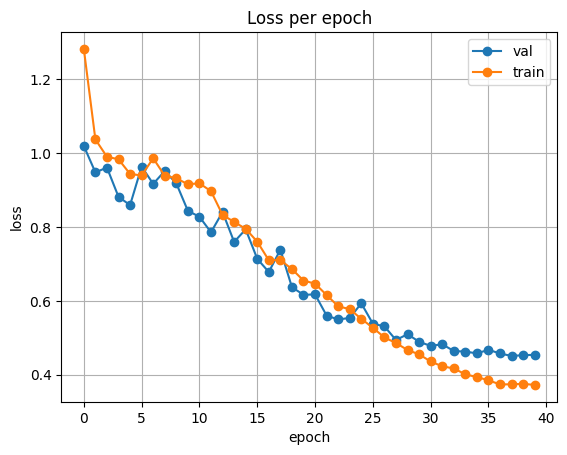

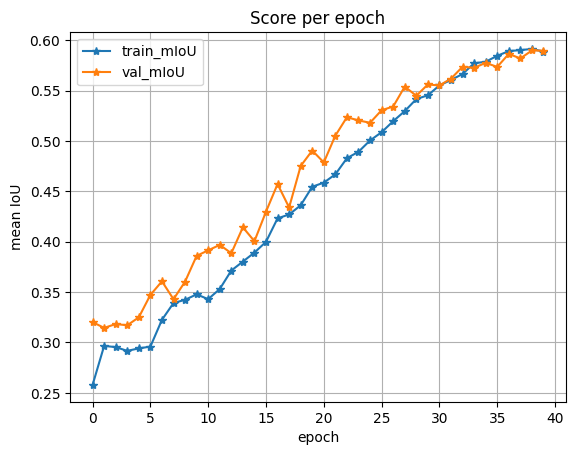

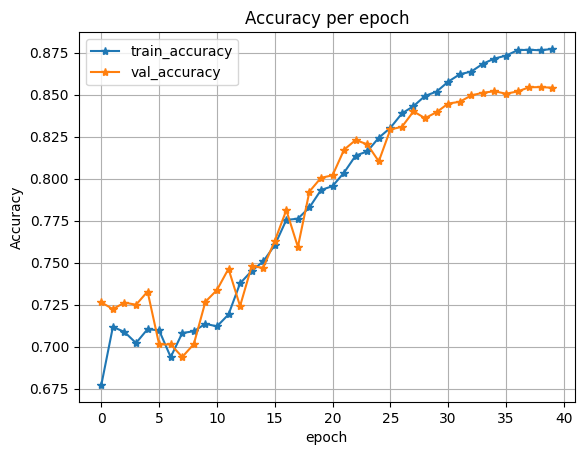

In [22]:
plot_loss(history)
plot_score(history)
plot_acc(history)